In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.platform.automl_v4 import AutoML_v4
from pptoolbox.platform.automl_v4.utils import cross_group_predict
from pptoolbox.platform.automl_v4.loss_functions import *
from pptoolbox.platform.automl_v4.stop_functions import stopping_criteria

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score

import warnings
warnings.simplefilter("ignore")

import pickle as pkl
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
def classify_median_pred(pipeline, X):
    preds = pd.DataFrame(pipeline.predict_proba(X), index = X.index)
    preds_median = preds.groupby(preds.index).median()
    preds_median_argmax = np.argmax(preds_median.values, axis=1)

    return preds_median_argmax

# import data

In [50]:
datasets = {
    'ethanol':{
        'randomsplit': {},
        'timesplit': {}
    },
    # 'dry':{}
}

split_methods = [
    'randomsplit',
    'timesplit'
]
# split = split_methods[1]

In [52]:
for split_method in split_methods:
    for dataset in datasets:

        print(f'Processing {split_method} from {dataset} dataset...')

        save_dir = f"../data/processed/{dataset}/{split_method}"

        X_train = pd.read_csv(f'{save_dir}/Xtrain.csv', index_col=0)
        X_test = pd.read_csv(f'{save_dir}/Xtest.csv', index_col=0)
        y_train = pd.read_csv(f'{save_dir}/ytrain.csv', index_col=0)
        y_test = pd.read_csv(f'{save_dir}/ytest.csv', index_col=0)

        datasets[dataset][split_method]['X_train'] = X_train
        datasets[dataset][split_method]['X_test'] = X_test
        datasets[dataset][split_method]['y_train'] = y_train[['Condition']]
        datasets[dataset][split_method]['y_test'] = y_test[['Condition']]

        print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
        print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')
        print()

Processing randomsplit from ethanol dataset...
X_train: (132, 191), y_train: (132, 5)
X_test: (36, 191), y_test: (36, 5)

Processing timesplit from ethanol dataset...
X_train: (137, 191), y_train: (137, 5)
X_test: (31, 191), y_test: (31, 5)



# Classify

In [53]:
for split_method in split_methods:
    for dataset in datasets:

        print(f'Processing {split_method} {dataset} dataset')
        X_train = datasets[dataset][split_method]['X_train']
        y_train = datasets[dataset][split_method]['y_train']

        for i, col in enumerate(y_train.select_dtypes(include=['object']).columns):

            print(f'Training model for {col}')
            
            output_dir = Path(f"../models/automl/{dataset}/{split_method}/{col}")
            output_dir.mkdir(parents=True, exist_ok=True)
            selected_y_train = y_train[col]

            #check if encoder exists
            if (output_dir / "encoder.pkl").exists():
                encoder = pkl.load(open(output_dir / "encoder.pkl", "rb"))
                selected_y_train_encoded = pd.Series(
                    encoder.transform(selected_y_train),
                    index = selected_y_train.index
                )
            else:
                encoder = LabelEncoder()
                selected_y_train_encoded = pd.Series(
                    encoder.fit_transform(selected_y_train),
                    index = selected_y_train.index
                )

                pkl.dump(encoder, open(output_dir / "encoder.pkl", "wb"))

            # check if model exists
            if (output_dir / "trainer.pkl").exists():
                print("Model exists, skipping training")
            else:
                trainer = AutoML_v4(
                    task_type = "classify", 
                    exploration = 150,
                    exploitation = 250,
                )

                trainer.fit(X_train, selected_y_train_encoded)
                pkl.dump(trainer, open(
                    output_dir / "trainer.pkl", "wb"
                ))
                pkl.dump(trainer.get_pipeline(), open(
                    output_dir / "origin_model_prediction.pkl", "wb"
                ))

Processing randomsplit ethanol dataset
Training model for Condition
100%|██████████| 400/400 [01:20<00:00,  5.00trial/s, best loss: 0.2732498982498983]
Processing timesplit ethanol dataset
Training model for Condition
100%|██████████| 400/400 [01:14<00:00,  5.38trial/s, best loss: 0.25620675620675615]


In [54]:
# inspect trainer
for split_method in split_methods:
    for dataset in datasets:

        print(f'Loading {split_method} {dataset} trainer')
        for col in datasets[dataset][split_method]['y_train'].columns:
            if datasets[dataset][split_method]['y_train'][col].dtype == 'float64':
                # print(f'{col} is a float64 column, skipping')
                continue
            print(f'Inspecting model for {col}')
            
            output_dir = Path(f"../models/automl/{dataset}/{split_method}/{col}")
            trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))
            display(trainer.get_pipeline()
        )
        print()

Loading randomsplit ethanol trainer
Inspecting model for Condition


Pipeline(steps=[('Detrend', Detrend()),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=18, random_state=42)),
                ('SVC',
                 SVC(C=17.713966485320125, cache_size=2000, kernel='linear',
                     probability=True, random_state=42))])


Loading timesplit ethanol trainer
Inspecting model for Condition


Pipeline(steps=[('Detrend', Detrend()),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=3, random_state=42)),
                ('LogisticRegression',
                 LogisticRegression(C=99.06131035328816,
                                    l1_ratio=0.38332094187458055,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga'))])

# Custom Chain Model

Model will first predict Pass (1Pass), or Defect (2Mild, 3Rancid) before predicting 2Mild or 3Rancid for Defect

In [7]:
# %reload_ext autoreload
# %autoreload 2
# from hierarchical_classifier_passdefect import HierarchicalClassifier

In [8]:
# for dataset in datasets:

#     # if dataset !="nondeo":
#     #     continue

#     print(f'Processing {dataset} dataset')
#     X_train = datasets[dataset]['X_train']
#     y_train = datasets[dataset]['y_train']

#     for i, col in enumerate(y_train.select_dtypes(include=['object']).columns):

#         if col == 'Result':
#             continue

#         print(f'Training model for {col}')
        
#         output_dir = Path(f"../models/custom_chain/{dataset}/{col}")
#         output_dir.mkdir(parents=True, exist_ok=True)
#         selected_y_train = y_train[col]

#         #check if encoder exists
#         if (output_dir / "encoder.pkl").exists():
#             encoder = pkl.load(open(output_dir / "encoder.pkl", "rb"))
#             selected_y_train_encoded = pd.Series(
#                 encoder.transform(selected_y_train),
#                 index = selected_y_train.index
#             )
#         else:
#             encoder = LabelEncoder()
#             selected_y_train_encoded = pd.Series(
#                 encoder.fit_transform(selected_y_train),
#                 index = selected_y_train.index
#             )

#             pkl.dump(encoder, open(output_dir / "encoder.pkl", "wb"))

#         # check if model exists

#         if (output_dir / "trainer.pkl").exists():
#             print("Model exists, skipping training")
#         else:
#             encoder_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

#             # Create the hierarchical classifier with encoding
#             hierarchical_model = HierarchicalClassifier(encoder_mapping)

#             # Fit the model
#             hierarchical_model.fit(X_train, selected_y_train_encoded)

#             pkl.dump(hierarchical_model, open(
#                     output_dir /f"trainer.pkl", "wb"
#             ))

#             pipeline = hierarchical_model.get_pipeline()

#             pkl.dump(pipeline, open(
#                 output_dir / "origin_model_prediction.pkl", "wb"
#             ))

In [9]:
# # inspect trainer
# for dataset in datasets:
#     print(f'Loading {dataset} trainer')
#     for col in datasets[dataset]['y_train'].columns:
#         if datasets[dataset]['y_train'][col].dtype == 'float64':
#             # print(f'{col} is a float64 column, skipping')
#             continue
#         elif col == 'Result':
#             continue
#         print(f'Inspecting model for {col}')
        
#         output_dir = Path(f"../models/custom_chain/{dataset}/{col}")
#         trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))
#         pipeline = pkl.load(open(output_dir / "origin_model_prediction.pkl", "rb"))
#         display(pipeline.get_params())
#     print()

# combined cv and blinds

In [55]:
%autoreload 2
from plot_insights import plot_radar_charts

In [56]:
model_version = "automl"
# model_version = "custom_chain"

Processing ethanol dataset
Getting CV scores for Condition


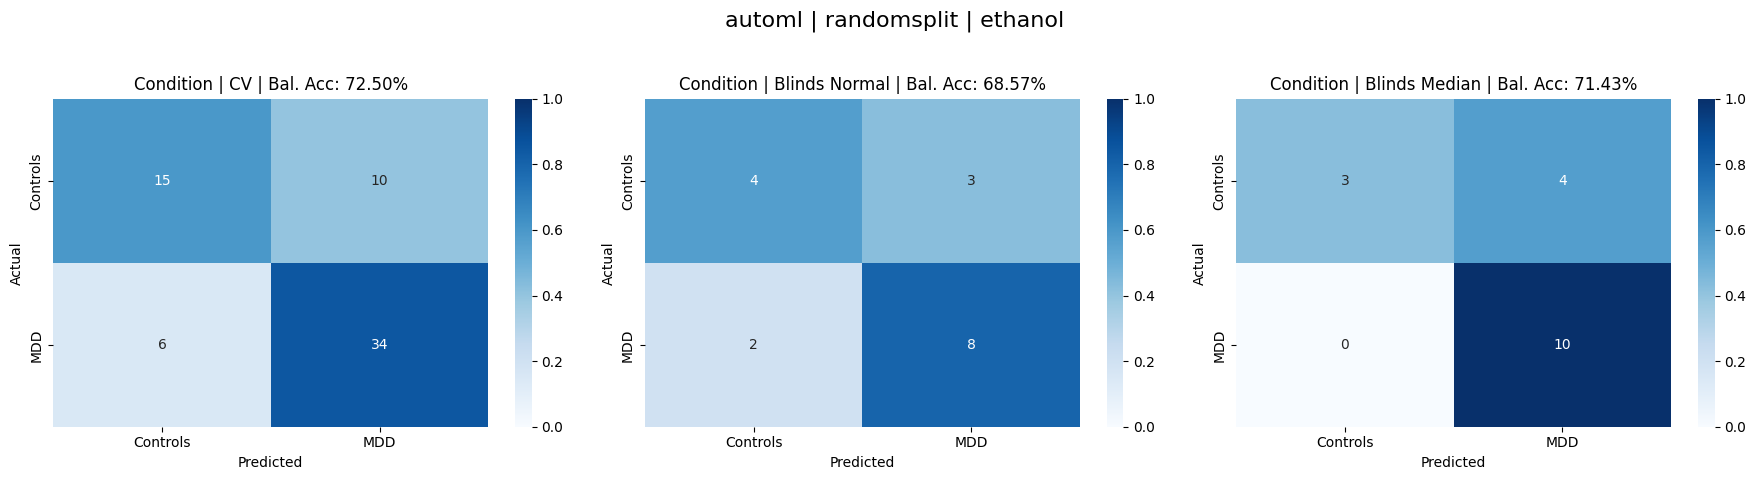

Processing ethanol dataset
Getting CV scores for Condition


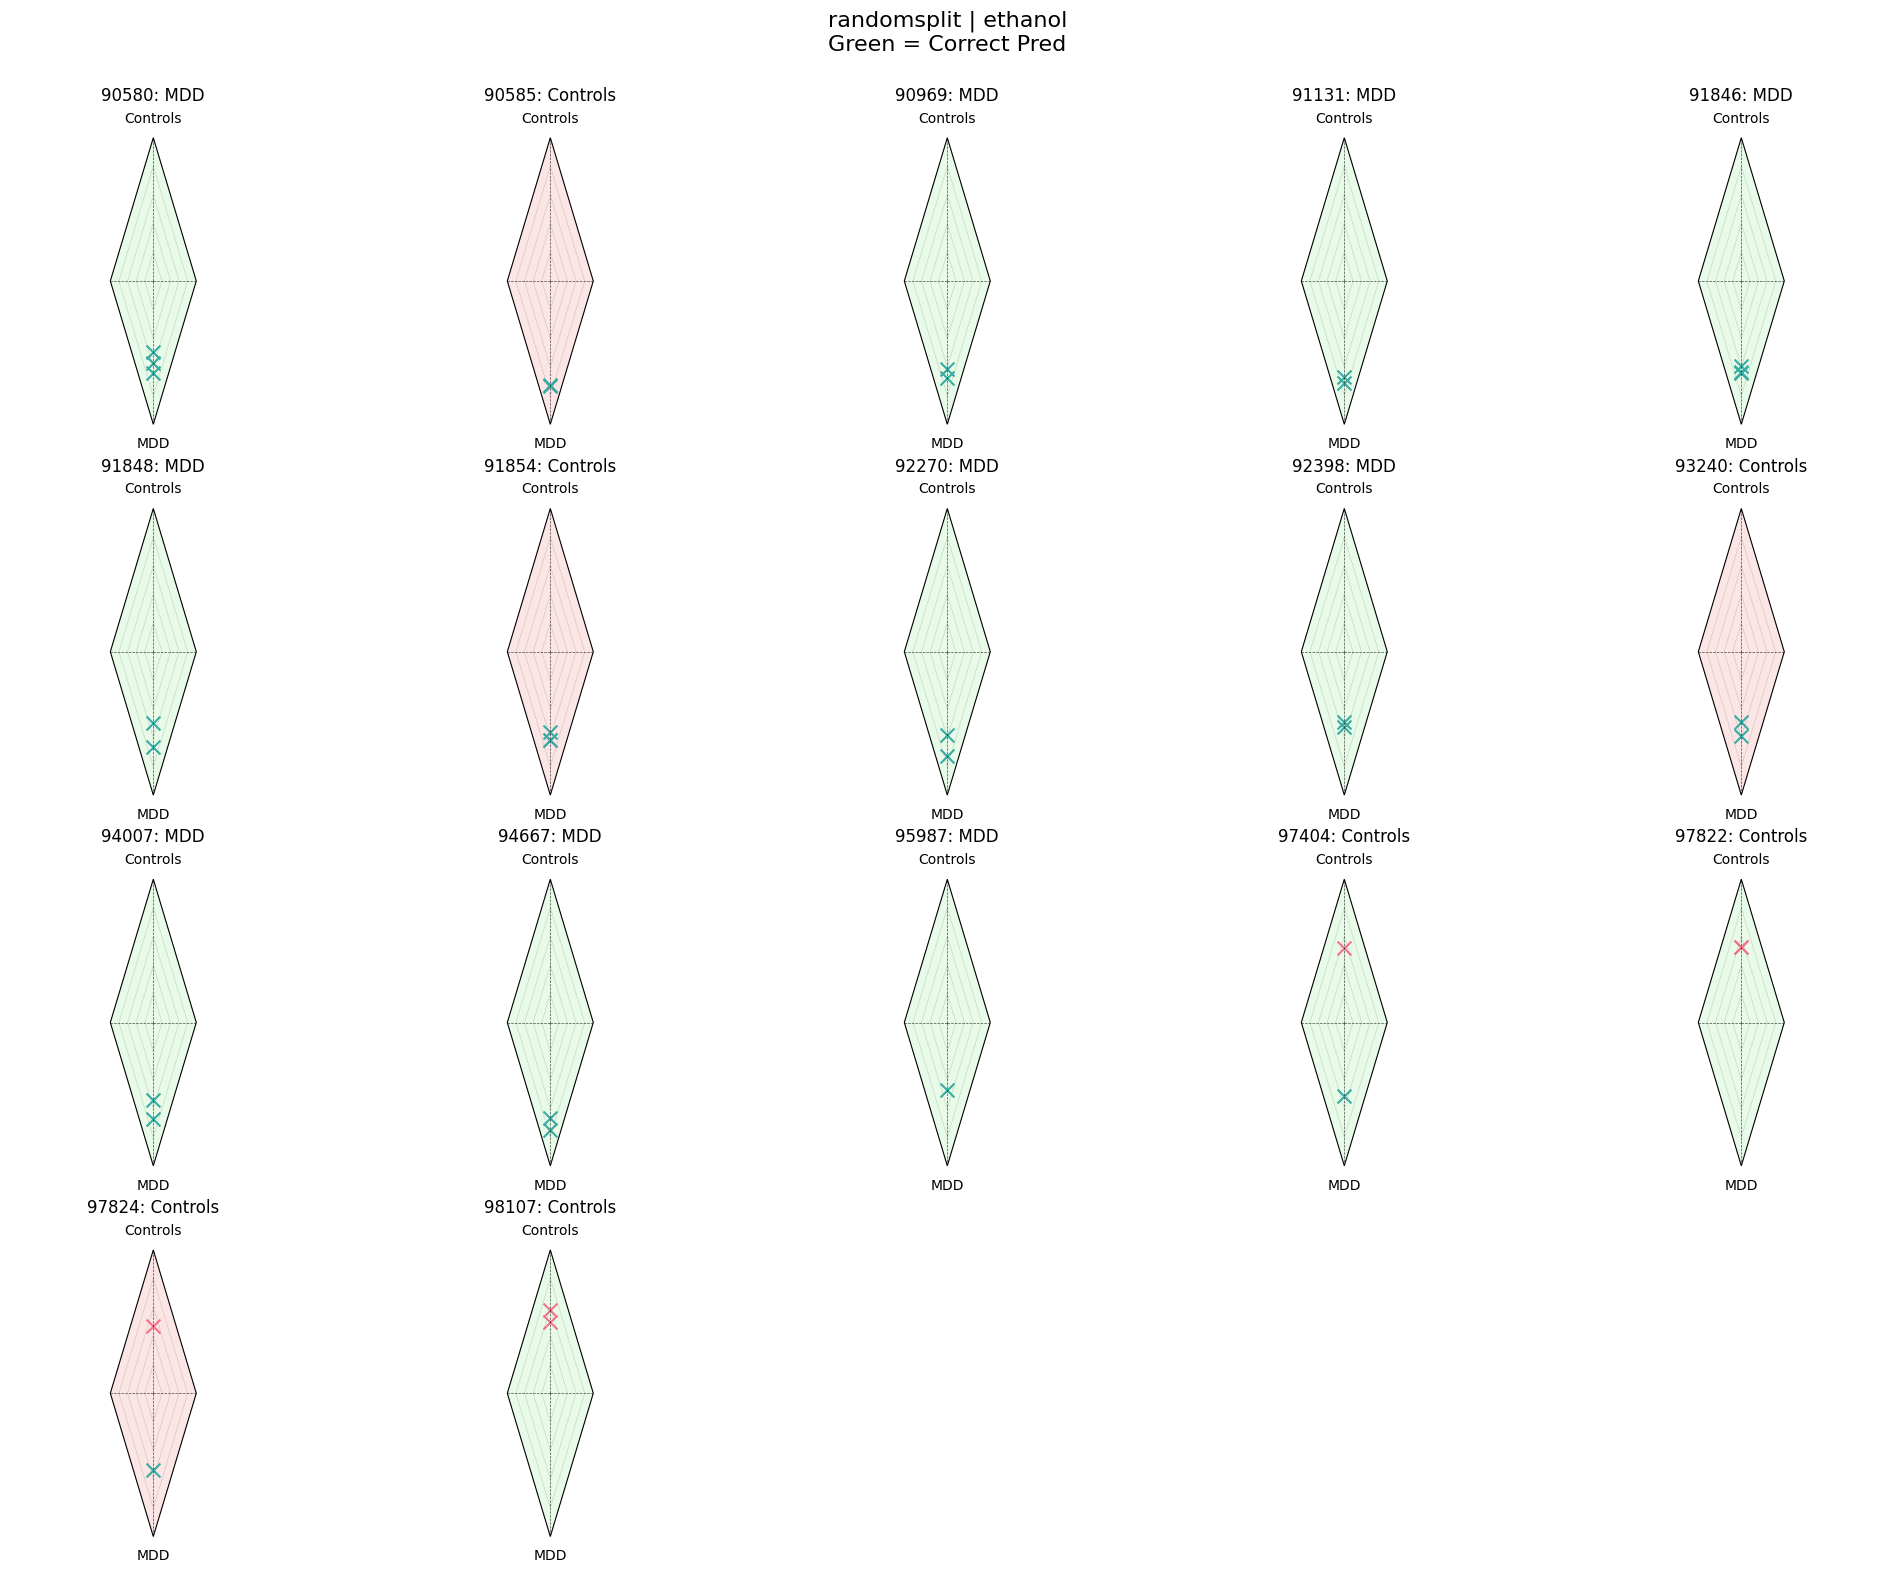

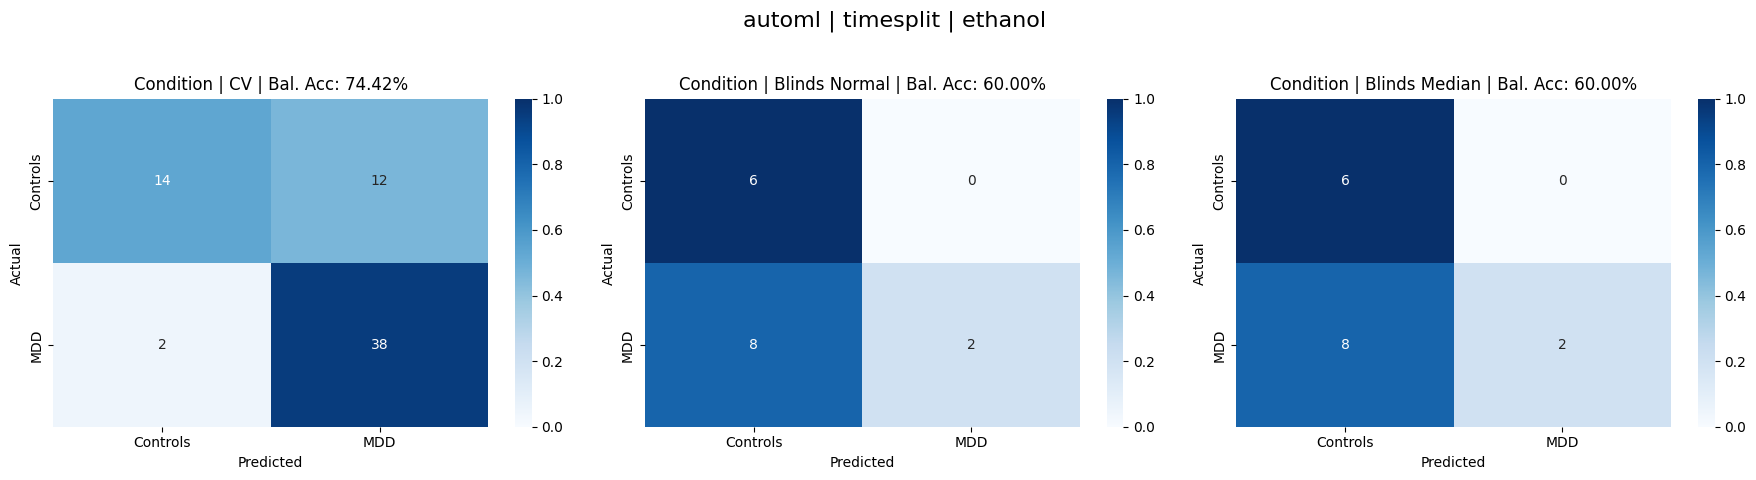

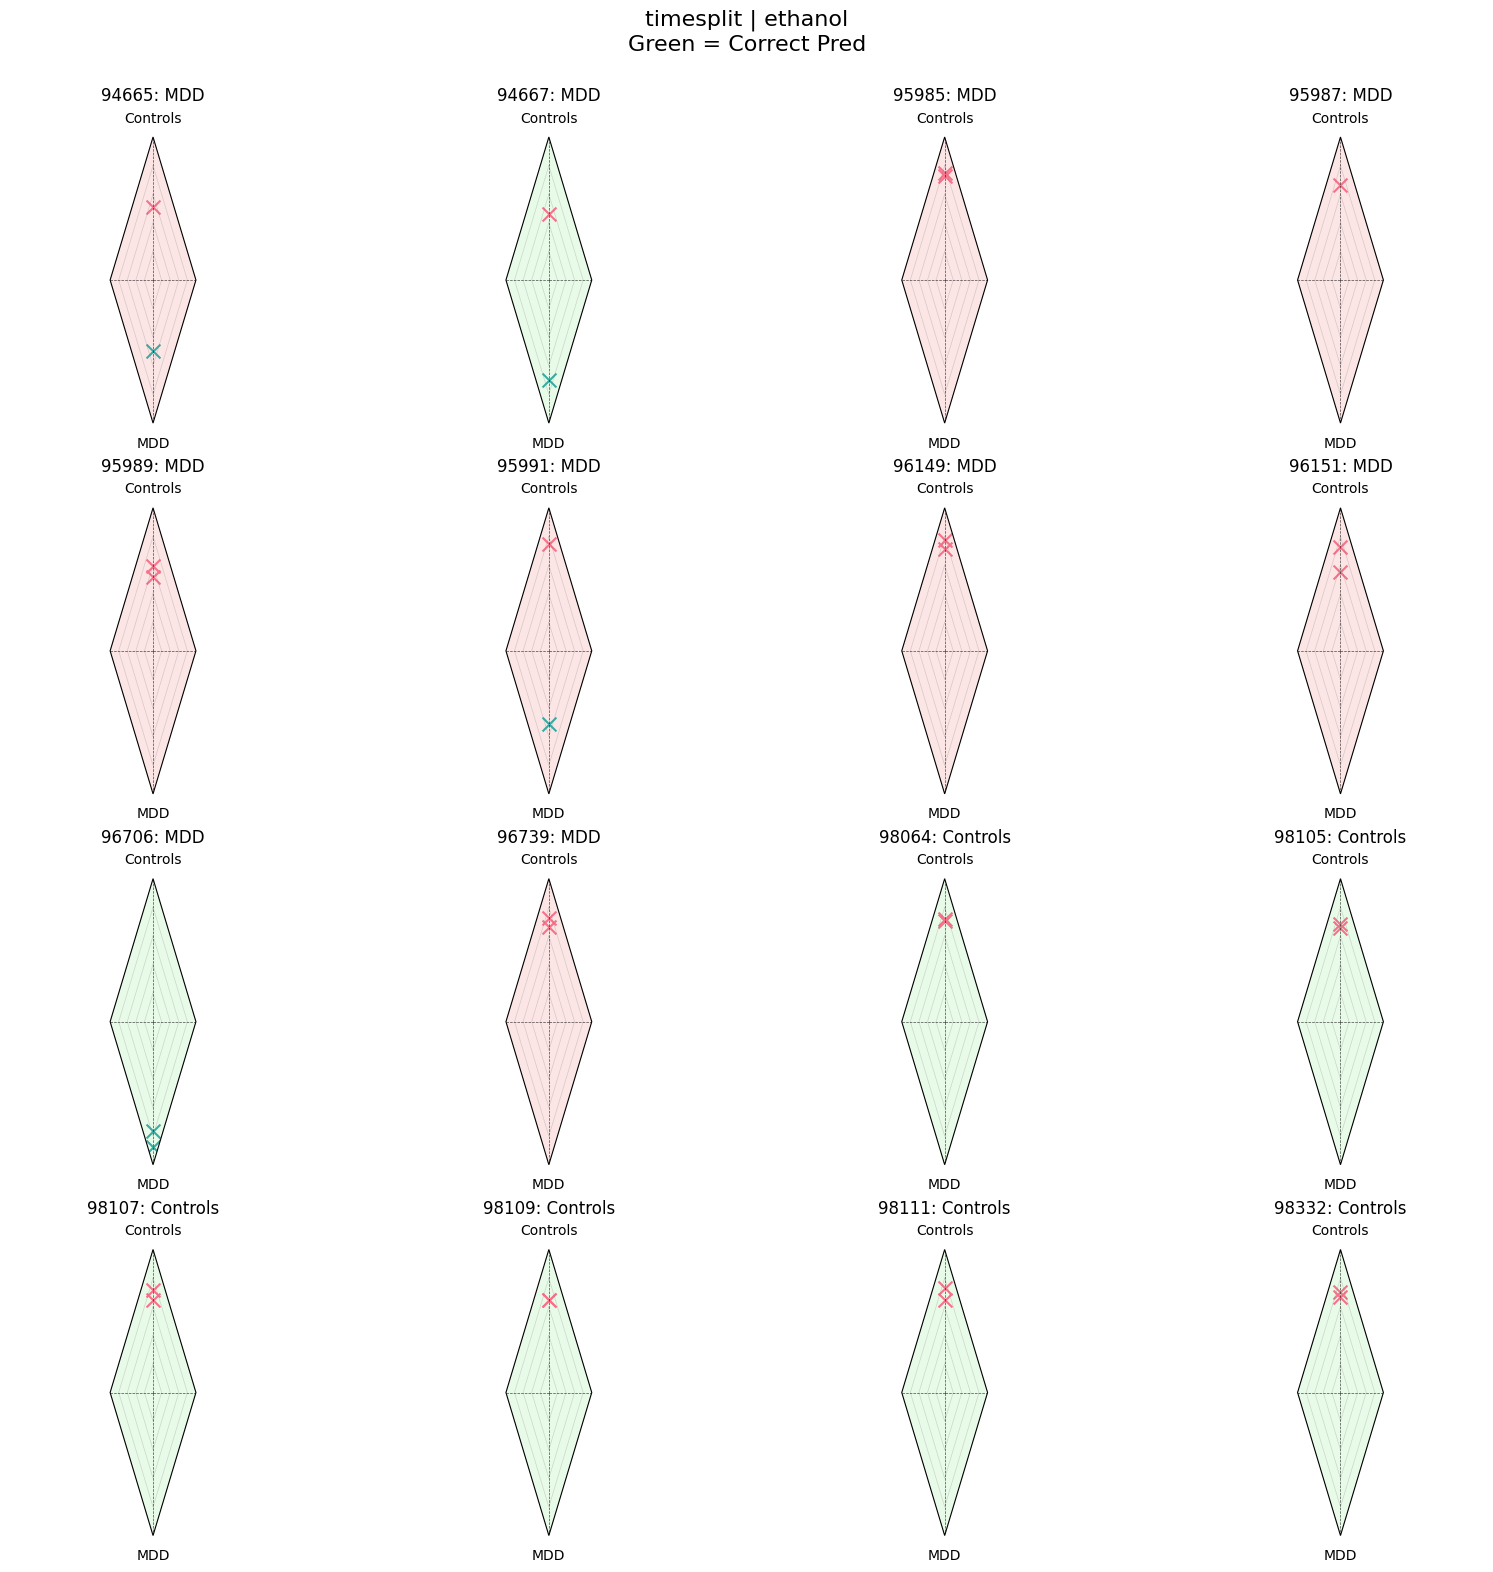

In [61]:
for split_method in split_methods:
    for dataset in datasets:

        print(f'Processing {dataset} dataset')
        X_train = datasets[dataset][split_method]['X_train']
        y_train = datasets[dataset][split_method]['y_train']
        X_test = datasets[dataset][split_method]['X_test']
        y_test = datasets[dataset][split_method]['y_test']

        # Count the number of categorical columns in y_train
        categorical_cols = [col for col in y_train.columns if y_train[col].dtype == 'object']

        for idx, col in enumerate(categorical_cols):

            # if idx>0:
            #     continue

            print(f'Getting CV scores for {col}')
            
            output_dir = Path(f"../models/{model_version}/{dataset}/{split_method}/{col}")
            output_dir.mkdir(parents=True, exist_ok=True)

            selected_y_train = y_train[col]
            selected_y_test = y_test[col]

            # Check if encoder exists
            encoder_path = output_dir / "encoder.pkl"
            if encoder_path.exists():
                encoder = pkl.load(open(encoder_path, "rb"))
                selected_y_train_encoded = pd.Series(
                    encoder.transform(selected_y_train),
                    index=selected_y_train.index
                )
                selected_y_test_encoded = pd.Series(
                    encoder.transform(selected_y_test),
                    index = selected_y_test.index
                )
            else:
                print("Encoder does not exist, skipping cv")
                continue

            # Check if model exists
            model_path = output_dir / "trainer.pkl"
            if model_path.exists():
                add_timeout(loss_function,30)
                stopping_criteria(None)
                trainer = pkl.load(open(model_path, "rb"))
            else:
                print("Model does not exist, skipping cv")
                continue

            # predict CV
            grouped_cv_pred = cross_group_predict(
                trainer.get_pipeline(),
                X=X_train,
                y=selected_y_train_encoded,
                cv=StratifiedGroupKFold(n_splits=3),
                groups=X_train.index
            )
            grouped_y_train = selected_y_train_encoded.groupby(selected_y_train_encoded.index).mean()

            # predict blinds
            ## normal
            grouped_X_test = X_test.groupby(X_test.index).mean()
            val_pred_normal = trainer.predict(grouped_X_test)
            val_predprobab_normal = trainer.predict_proba(grouped_X_test)
            ## median
            val_pred_median = classify_median_pred(trainer.get_pipeline(), X_test)

            grouped_selected_y_test = selected_y_test_encoded.groupby(selected_y_test_encoded.index).mean()

            def plot_cf_matrix(cnfm, cnfm_norm, ax):
                cnfm_settings = {
                    "cmap": "Blues",
                    "norm": Normalize(0, 1),
                    "annot": cnfm,
                    "fmt": ".0f",
                    "xticklabels": encoder.classes_,
                    "yticklabels": encoder.classes_,
                }

                sns.heatmap(cnfm_norm, ax=ax, **cnfm_settings)
                ax.set_xlabel("Predicted")
                ax.set_ylabel("Actual")

            
            ncols = 3  # At 3 columns, for CV, aggregated blinds, mode blinds
            nrows = 1

            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 5))
            fig.suptitle(f"{model_version} | {split_method} | {dataset}", fontsize=16)

            # Get subplot axes
            ax = axes[0]
            cnfm = confusion_matrix(grouped_y_train, grouped_cv_pred)
            cnfm_norm = confusion_matrix(grouped_y_train, grouped_cv_pred, normalize='true')
            bal_acc = balanced_accuracy_score(grouped_y_train, grouped_cv_pred)
            ax.set_title(f"{col} | CV | Bal. Acc: {bal_acc*100:.2f}%", fontsize=12)
            plot_cf_matrix(cnfm,cnfm_norm, ax)

            ax = axes[1]
            cnfm = confusion_matrix(grouped_selected_y_test, val_pred_normal)
            cnfm_norm = confusion_matrix(grouped_selected_y_test, val_pred_normal, normalize='true')
            bal_acc = balanced_accuracy_score(grouped_selected_y_test, val_pred_normal)
            ax.set_title(f"{col} | Blinds Normal | Bal. Acc: {bal_acc*100:.2f}%", fontsize=12)
            plot_cf_matrix(cnfm,cnfm_norm, ax)

            ax = axes[2]
            cnfm = confusion_matrix(grouped_selected_y_test, val_pred_median)
            cnfm_norm = confusion_matrix(grouped_selected_y_test, val_pred_median, normalize='true')
            bal_acc = balanced_accuracy_score(grouped_selected_y_test, val_pred_median)
            ax.set_title(f"{col} | Blinds Median | Bal. Acc: {bal_acc*100:.2f}%", fontsize=12)
            plot_cf_matrix(cnfm,cnfm_norm, ax)

        # # Hide any empty subplots
        # for idx in range(num_cols, nrows * ncols):  # Only affects extra subplots
        #     fig.delaxes(axes.flatten()[idx])  # Remove empty subplot

            # Adjust layout and save the combined figure
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.savefig(f"../models/{model_version}/{dataset}/{split_method}/{col}/cv_metrics_summary.png",bbox_inches = "tight")
            plt.show()
            plt.close()

        specimen_level_preds = trainer.get_pipeline().predict_proba(X_test)
        specimen_level_preds_df = pd.DataFrame(specimen_level_preds, index=X_test.index, columns=encoder.classes_)
        specimen_level_preds_median_argmax = specimen_level_preds_df.groupby(specimen_level_preds_df.index).median().values.argmax(axis=1)
        titles = [f"{grouped_selected_y_test.index[i]}: {encoder.inverse_transform(pd.DataFrame(grouped_selected_y_test).astype(int)[0])[i]}" for i in range(len(grouped_selected_y_test))]
        correct = specimen_level_preds_median_argmax == grouped_selected_y_test.values
        correct_dict = {
            lot_id: correct[i] for i, lot_id in enumerate(grouped_selected_y_test.index)
        }

        plot_radar_charts(specimen_level_preds_df, categories=encoder.classes_, titles=titles, correct=correct_dict, fig_title=f"{split_method} | {dataset}\nGreen = Correct Pred", top_space=0.9)